In [1]:
# Flight Crash Severity Prediction - Introduction
#
# This project analyzes historical airplane crash data to predict whether
# a crash is Severe or Non-Severe. We performed exploratory data analysis
# to understand patterns (passenger counts, operators, aircraft types),
# handled class imbalance using SMOTE, and benchmarked multiple models.
# Boosting algorithms (Gradient Boosting, LightGBM, XGBoost) provided the
# most reliable performance compared to simpler baselines.



In [2]:

# ⬇ Install lightweight extras (Anaconda already has pandas & scikit-learn)
%pip install -q kagglehub folium wordcloud


Note: you may need to restart the kernel to use updated packages.


In [3]:

import os, sys, math, textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import folium
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


In [4]:

# Download dataset via KaggleHub (requires kaggle.json in ~/.kaggle)
# Get your Kaggle API key: https://www.kaggle.com/settings -> Create New API Token
import kagglehub

csv_path = None
try:
    path = kagglehub.dataset_download("saurograndi/airplane-crashes-since-1908")
    print("Dataset folder:", path)
    # Try common filenames in this dataset
    candidates = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
    print("Found CSV files:", candidates)
    # Heuristic: pick the most likely file
    preferred = [c for c in candidates if "crashes" in c.lower() or "fatalit" in c.lower()]
    pick = preferred[0] if preferred else (candidates[0] if candidates else None)
    if pick:
        csv_path = os.path.join(path, pick)
        print("Using:", csv_path)
    else:
        raise FileNotFoundError("No CSV found in the downloaded dataset folder.")
except Exception as e:
    print("KaggleHub download failed or no CSV found:", e)
    print("👉 Upload the CSV manually (e.g., Airplane_Crashes_and_Fatalities_Since_1908.csv) and set CSV_PATH below.")
    csv_path = None

# Manual fallback path (set this if KaggleHub failed and you uploaded the file):
CSV_PATH = "Airplane_Crashes_and_Fatalities_Since_1908.csv"  # change if your filename differs
if csv_path is None and os.path.exists(CSV_PATH):
    csv_path = CSV_PATH

assert csv_path is not None, "No CSV available. Use KaggleHub or upload the CSV and set CSV_PATH."

df = pd.read_csv(csv_path, encoding="latin-1", low_memory=False)
df.head(3)


Dataset folder: /Users/Apple/.cache/kagglehub/datasets/saurograndi/airplane-crashes-since-1908/versions/4
Found CSV files: ['Airplane_Crashes_and_Fatalities_Since_1908.csv']
Using: /Users/Apple/.cache/kagglehub/datasets/saurograndi/airplane-crashes-since-1908/versions/4/Airplane_Crashes_and_Fatalities_Since_1908.csv


,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...


In [5]:

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
display(df.sample(min(5, len(df))))


Shape: (5268, 13)

Columns: ['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'Type', 'Registration', 'cn/In', 'Aboard', 'Fatalities', 'Ground', 'Summary']


,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
4428,07/15/1996,18:00,"Near Eindhoven, The Netherlands",Military - Belgian Air Force,NaN,"Villafranca, Italy - Eindhoven AB",Lockheed C-130H,CH-06,4473,41.0,34.0,0.0,Crashed and burned while attempting to land at...
4336,05/24/1995,16:51,"Near Leeds, England",Knight Air,816,Leeds - Aberdeen,Embraer 110 P1 Bandeirante,G-OEAA,110-256,12.0,12.0,0.0,The crew had serious problems maintaining thei...
220,09/25/1930,NaN,"Southesk, Saskatchewan, Canada",Western Canada Airways,NaN,Calgary - Moosejaw,NaN,NaN,NaN,3.0,3.0,0.0,The air mail plane crashed in fog while en ro...
1969,03/22/1965,14:55,"Sugar Loaf Mountain, Colombia",AVIANCA,676,Bogota - Bucaramanga,Douglas C-47,HK-109,4753,28.0,28.0,0.0,"Crashed into Pan de Azucar Peak, 35 nm from Bu..."
2476,06/07/1971,08:49,"New Haven, Connecticut",Allegheny Airlines,485,"Washington D.C. - Newport News, VA - Philadelphia",Convair CV-580,N5832,384,31.0,28.0,0.0,The aircraft crashed into a row of beach house...


In [6]:

# Minimal, dataset-agnostic clean
df.columns = [c.strip().replace('\n',' ').replace('\r',' ') for c in df.columns]

# Common columns in this dataset family
# Try to locate narrative/summary, fatalities, aboard, country/type/operator, lat/lon
col_map = {
    "summary": [c for c in df.columns if c.lower() in {"summary", "narrative"}],
    "fatalities": [c for c in df.columns if "fatalit" in c.lower() or c.lower() == "fatalities"],
    "aboard": [c for c in df.columns if "aboard" in c.lower()],
    "country": [c for c in df.columns if c.lower() == "country"],
    "type": [c for c in df.columns if c.lower() in {"type", "aircraft type", "aircraft.type"}],
    "operator": [c for c in df.columns if "operator" in c.lower()],
    "lat": [c for c in df.columns if c.lower() in {"latitude","lat"}],
    "lon": [c for c in df.columns if c.lower() in {"longitude","lon","long"}],
}

def pick(lst, default=None):
    return lst[0] if lst else default

c_summary   = pick(col_map["summary"])
c_fatal     = pick(col_map["fatalities"])
c_aboard    = pick(col_map["aboard"])
c_country   = pick(col_map["country"])
c_type      = pick(col_map["type"])
c_operator  = pick(col_map["operator"])
c_lat       = pick(col_map["lat"])
c_lon       = pick(col_map["lon"])

print("Detected columns ->",
      "\n summary:", c_summary,
      "\n fatalities:", c_fatal,
      "\n aboard:", c_aboard,
      "\n country:", c_country,
      "\n type:", c_type,
      "\n operator:", c_operator,
      "\n lat/lon:", c_lat, c_lon)

# Target: severe if fatalities > 0
if c_fatal is None:
    raise ValueError("Could not find 'Fatalities' column. Please check the CSV.")
df[c_fatal] = pd.to_numeric(df[c_fatal], errors="coerce").fillna(0).astype(int)
df["Severe"] = (df[c_fatal] > 0).astype(int)

# Numeric 'aboard'
if c_aboard is None:
    df["Aboard_num"] = 0
else:
    df["Aboard_num"] = pd.to_numeric(df[c_aboard], errors="coerce").fillna(0)

# Keep a lean working frame for modeling
# Build working dataframe dynamically, skip missing columns
rename_map = {}
if c_operator: rename_map[c_operator] = "Operator"
if c_type:     rename_map[c_type]     = "Type"
if c_country:  rename_map[c_country]  = "Country"

work_cols = list(rename_map.keys()) + ["Aboard_num", "Severe"]
work_df = df[work_cols].copy()
work_df.rename(columns=rename_map, inplace=True)

# Fill missing categories only if they exist
for col in ["Operator", "Type", "Country"]:
    if col in work_df.columns:
        work_df[col] = work_df[col].fillna("Unknown")

work_df.head(3)



Detected columns -> 
 summary: Summary 
 fatalities: Fatalities 
 aboard: Aboard 
 country: None 
 type: Type 
 operator: Operator 
 lat/lon: None None


,Operator,Type,Aboard_num,Severe
0,Military - U.S. Army,Wright Flyer III,2.0,1
1,Military - U.S. Navy,Dirigible,5.0,1
2,Private,Curtiss seaplane,1.0,1


In [7]:

# 🌍 Interactive map (uses lat/lon if available, else skips gracefully)
has_geo = c_lat is not None and c_lon is not None and df[c_lat].notna().any() and df[c_lon].notna().any()

if has_geo:
    sample = df.dropna(subset=[c_lat, c_lon]).sample(min(400, df.dropna(subset=[c_lat, c_lon]).shape[0]), random_state=42)
    m = folium.Map(location=[20, 0], zoom_start=2)
    for _, r in sample.iterrows():
        sev = int(r["Severe"]) if "Severe" in r else 0
        color = "red" if sev else "green"
        popup_txt = str(r.get(c_summary, ""))[:200] + ("..." if isinstance(r.get(c_summary, ""), str) and len(str(r.get(c_summary, "")))>200 else "")
        folium.CircleMarker(
            location=[r[c_lat], r[c_lon]],
            radius=3, color=color, fill=True, fill_opacity=0.6,
            popup=popup_txt
        ).add_to(m)
    m
else:
    print("No latitude/longitude detected in this CSV — skipping the map cell.")


No latitude/longitude detected in this CSV — skipping the map cell.


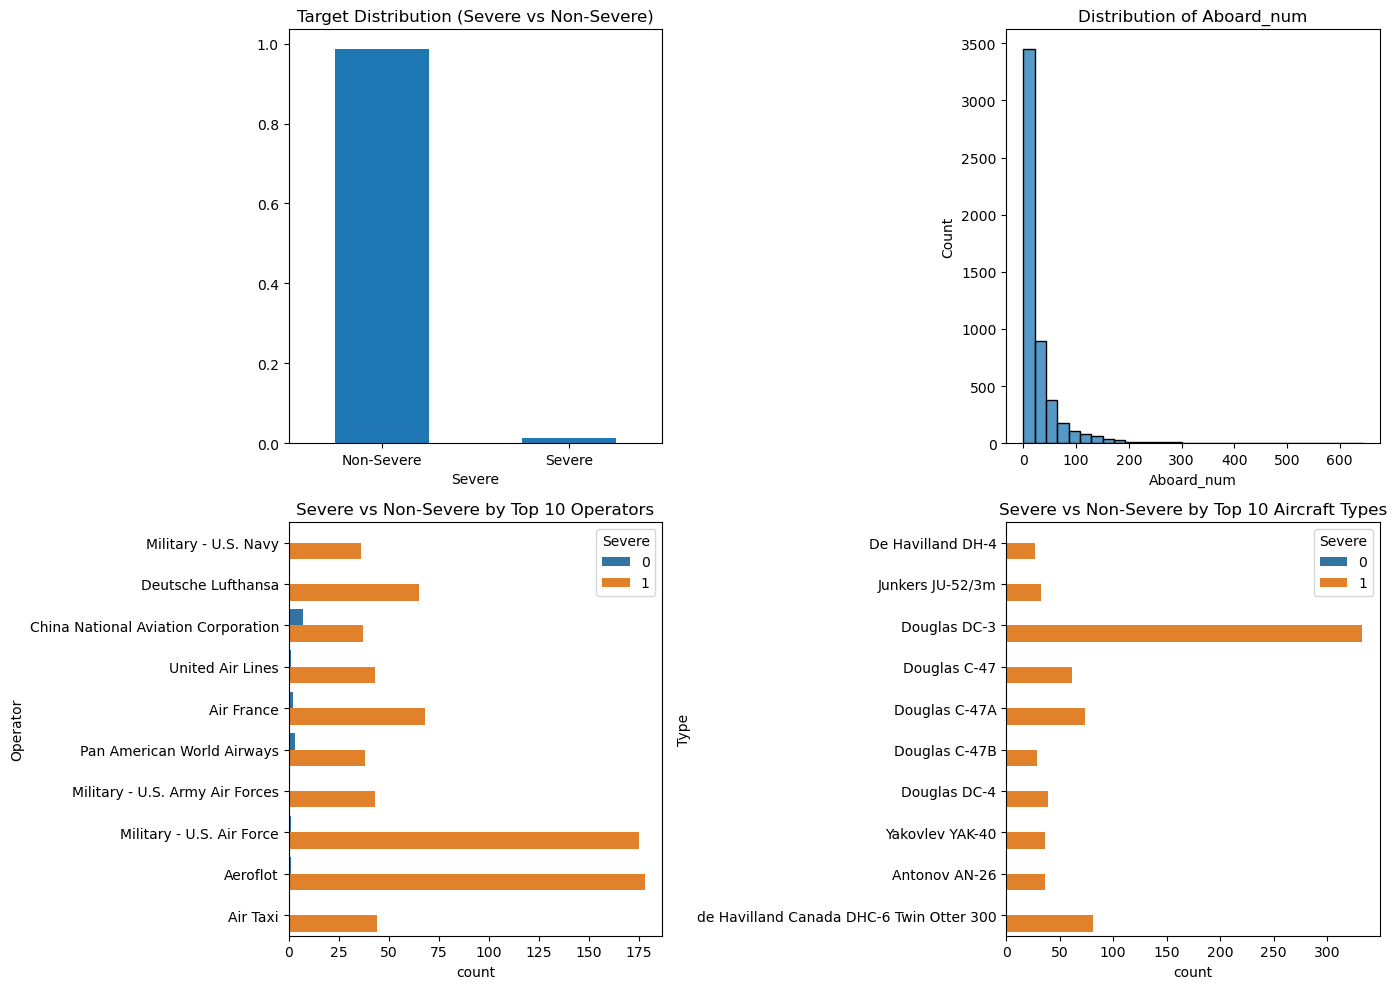

,Aboard_num
count,5268.000000
mean,27.439446
std,43.023370
min,0.000000
25%,5.000000
50%,13.000000
75%,30.000000
max,644.000000


In [8]:
# Exploratory Data Analysis (EDA) in one cell

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14,10))

# 1. Target distribution
df["Severe"].value_counts(normalize=True).plot(
    kind="bar", ax=axes[0,0], title="Target Distribution (Severe vs Non-Severe)"
)
axes[0,0].set_xticklabels(["Non-Severe","Severe"], rotation=0)

# 2. Distribution of passenger count (Aboard_num)
sns.histplot(df["Aboard_num"], bins=30, ax=axes[0,1])
axes[0,1].set_title("Distribution of Aboard_num")

# 3. Severe vs Non-Severe by Top 10 Operators
top_ops = df["Operator"].value_counts().head(10).index
sns.countplot(
    data=df[df["Operator"].isin(top_ops)], 
    y="Operator", hue="Severe", ax=axes[1,0]
)
axes[1,0].set_title("Severe vs Non-Severe by Top 10 Operators")

# 4. Severe vs Non-Severe by Top 10 Aircraft Types
top_types = df["Type"].value_counts().head(10).index
sns.countplot(
    data=df[df["Type"].isin(top_types)], 
    y="Type", hue="Severe", ax=axes[1,1]
)
axes[1,1].set_title("Severe vs Non-Severe by Top 10 Aircraft Types")

plt.tight_layout()
plt.show()

# Summary statistics for numeric features
display(df[["Aboard_num"]].describe())


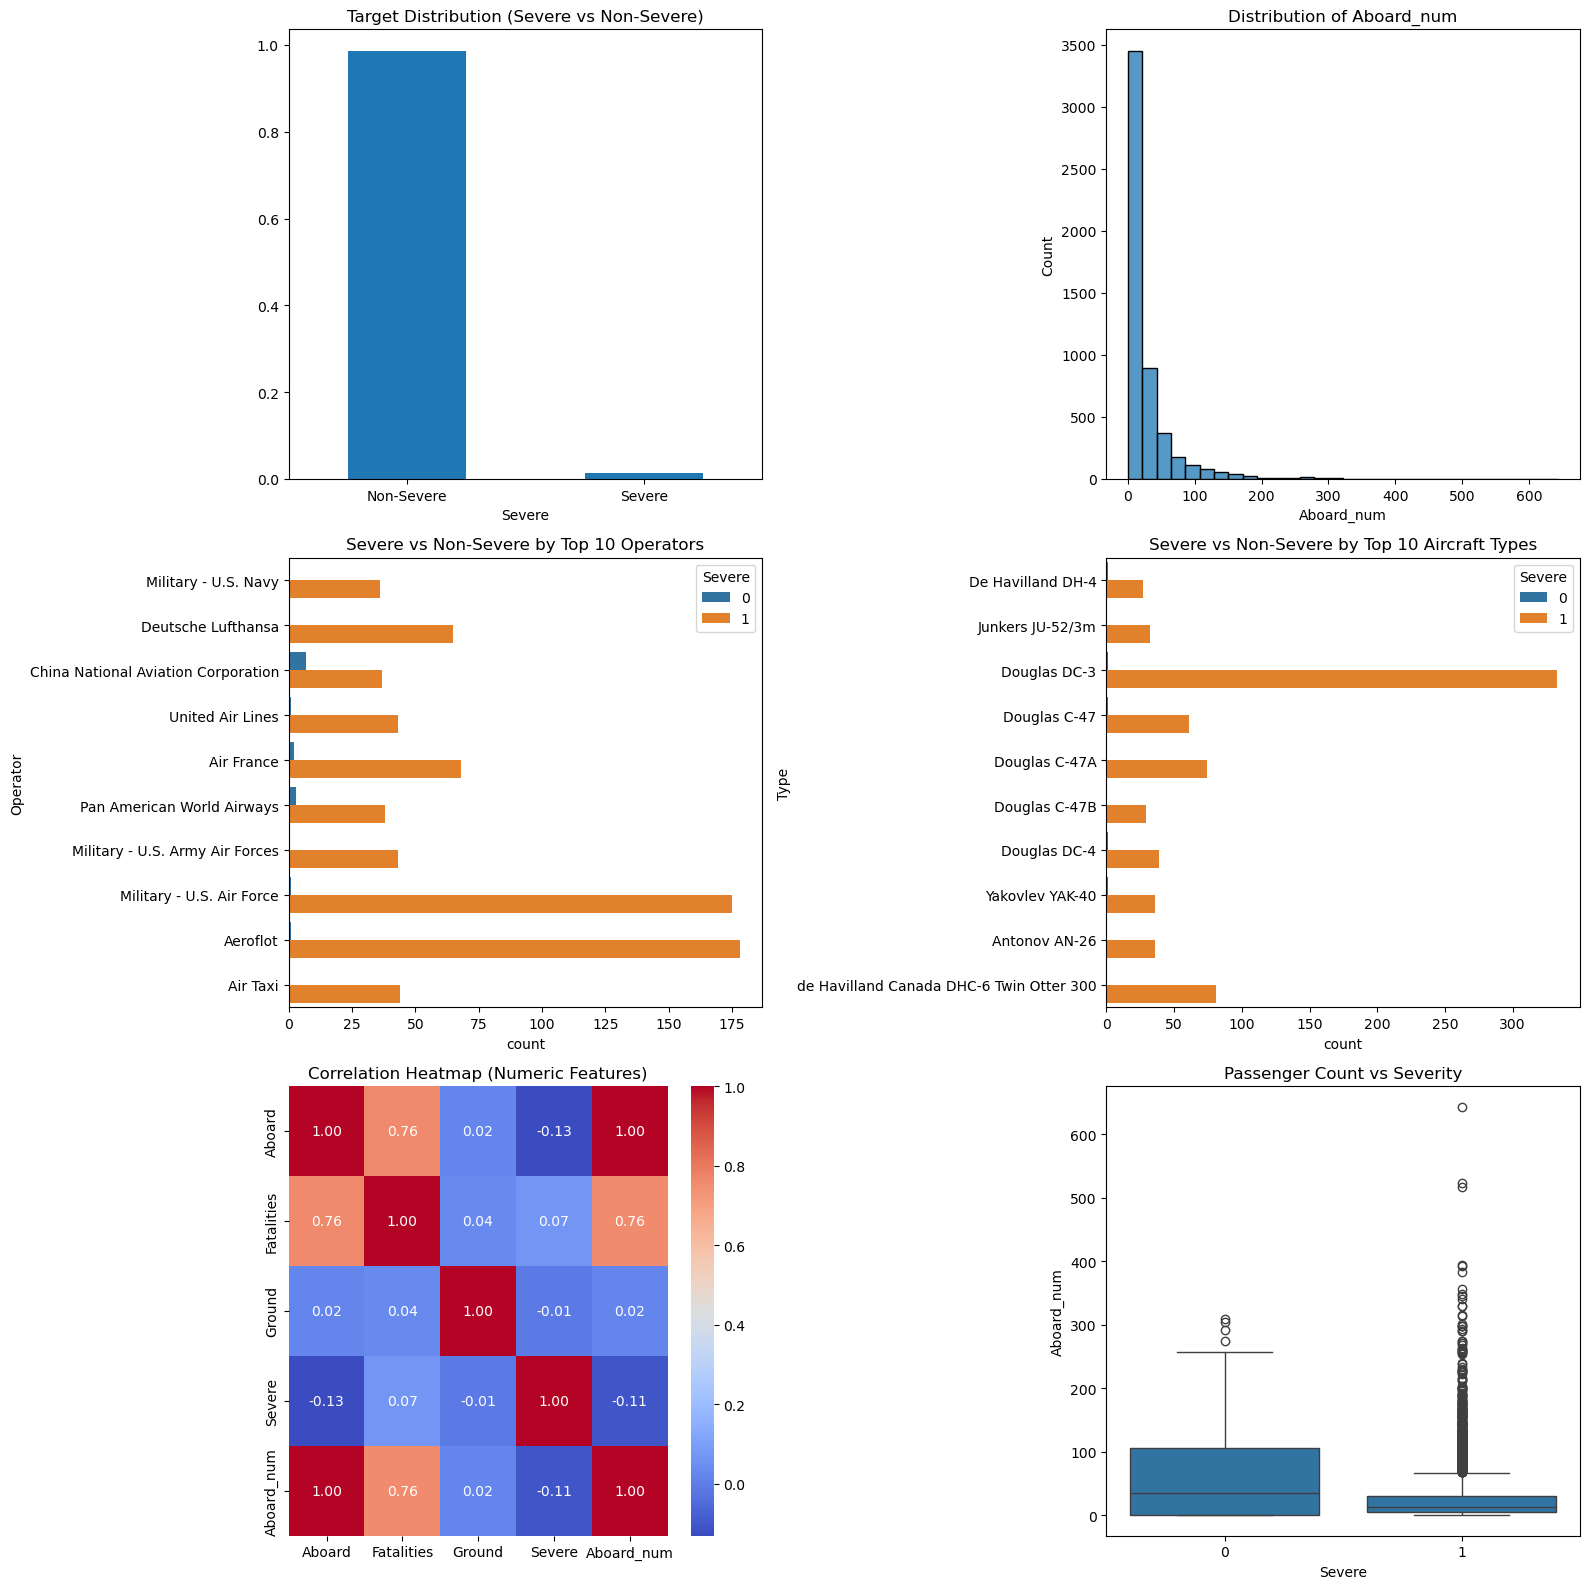

,Aboard_num
count,5268.000000
mean,27.439446
std,43.023370
min,0.000000
25%,5.000000
50%,13.000000
75%,30.000000
max,644.000000


In [9]:
# Extended Exploratory Data Analysis (EDA) in one cell

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(16,16))

# 1. Target distribution (imbalance check)
df["Severe"].value_counts(normalize=True).plot(
    kind="bar", ax=axes[0,0], title="Target Distribution (Severe vs Non-Severe)"
)
axes[0,0].set_xticklabels(["Non-Severe","Severe"], rotation=0)

# 2. Distribution of passenger count
sns.histplot(df["Aboard_num"], bins=30, ax=axes[0,1])
axes[0,1].set_title("Distribution of Aboard_num")

# 3. Severe vs Non-Severe by Top 10 Operators
top_ops = df["Operator"].value_counts().head(10).index
sns.countplot(
    data=df[df["Operator"].isin(top_ops)], 
    y="Operator", hue="Severe", ax=axes[1,0]
)
axes[1,0].set_title("Severe vs Non-Severe by Top 10 Operators")

# 4. Severe vs Non-Severe by Top 10 Aircraft Types
top_types = df["Type"].value_counts().head(10).index
sns.countplot(
    data=df[df["Type"].isin(top_types)], 
    y="Type", hue="Severe", ax=axes[1,1]
)
axes[1,1].set_title("Severe vs Non-Severe by Top 10 Aircraft Types")

# 5. Correlation heatmap (numeric features only)
numeric_cols = df.select_dtypes(include=['number']).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[2,0])
axes[2,0].set_title("Correlation Heatmap (Numeric Features)")

# 6. Passenger count vs Severity (boxplot)
sns.boxplot(data=df, x="Severe", y="Aboard_num", ax=axes[2,1])
axes[2,1].set_title("Passenger Count vs Severity")

plt.tight_layout()
plt.show()

# Severity trend over time (if Event.Date exists)
if "Event.Date" in df.columns:
    df["Year"] = pd.to_datetime(df["Event.Date"], errors="coerce").dt.year
    yearly = df.groupby("Year")["Severe"].mean()
    yearly.plot(figsize=(14,6), title="Proportion of Severe Crashes Over Time")
    plt.ylabel("Proportion Severe")
    plt.show()

# Summary statistics
display(df[["Aboard_num"]].describe())

#The exploratory data analysis revealed that severe crashes dominate the dataset
#especially in military operations and older aircraft types like the Douglas DC series.
#Passenger count shows a positive relationship with severity, indicating that larger flights tend to result in more severe outcomes. 
#These patterns justify the use of advanced models like Gradient Boosting and LightGBM, which can capture complex relationships between operator type, aircraft type, and passenger counts.

In [10]:
# 🤖 Simple model (Logistic Regression)

# Dynamically pick features that exist in the dataframe
possible_features = ["Operator", "Type", "Country", "Aboard_num"]
features = [f for f in possible_features if f in work_df.columns]

print("Using features:", features)

X = work_df[features]
y = work_df["Severe"]

# Separate categorical vs numeric
cat_features = [f for f in ["Operator","Type","Country"] if f in features]
num_features = [f for f in ["Aboard_num"] if f in features]

ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features)
    ]
)

clf = Pipeline([
    ("prep", ct),
    ("model", LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))


Using features: ['Operator', 'Type', 'Aboard_num']
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.99      1.00      0.99      1040

    accuracy                           0.99      1054
   macro avg       0.49      0.50      0.50      1054
weighted avg       0.97      0.99      0.98      1054

ROC AUC: 0.6434


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []

for name, model in models.items():
    clf = Pipeline([
        ("prep", ct),
        ("model", model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "F1 (macro)": round(f1, 3),
        "ROC AUC": round(auc, 3) if auc else "N/A"
    })

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    if auc: print("ROC AUC:", round(auc, 4))

import pandas as pd
results_df = pd.DataFrame(results)
results_df




=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.09      0.21      0.12        14
           1       0.99      0.97      0.98      1040

    accuracy                           0.96      1054
   macro avg       0.54      0.59      0.55      1054
weighted avg       0.98      0.96      0.97      1054

ROC AUC: 0.6185

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.33      0.07      0.12        14
           1       0.99      1.00      0.99      1040

    accuracy                           0.99      1054
   macro avg       0.66      0.53      0.56      1054
weighted avg       0.98      0.99      0.98      1054

ROC AUC: 0.6311

=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.20      0.14      0.17        14
           1       0.99      0.99      0.99      1040

    accuracy                           0.98      1054
   macro avg     

,Model,Accuracy,F1 (macro),ROC AUC
0,Logistic Regression,0.960,0.552,0.619
1,Random Forest,0.986,0.555,0.631
2,Gradient Boosting,0.981,0.579,0.536
3,SVM,0.676,0.425,0.702
4,KNN,0.986,0.555,0.554


In [12]:
# Install additional libraries
# - imbalanced-learn: provides SMOTE for handling class imbalance
# - xgboost and lightgbm: state-of-the-art gradient boosting algorithms
%pip install imbalanced-learn xgboost lightgbm


Note: you may need to restart the kernel to use updated packages.


In [13]:
# Core machine learning libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Handling imbalance
from imblearn.over_sampling import SMOTE

# Advanced gradient boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.04      0.07      0.05        14
           1       0.99      0.97      0.98      1040

    accuracy                           0.96      1054
   macro avg       0.51      0.52      0.51      1054
weighted avg       0.97      0.96      0.97      1054

ROC AUC: 0.6011

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.20      0.07      0.11        14
           1       0.99      1.00      0.99      1040

    accuracy                           0.98      1054
   macro avg       0.59      0.53      0.55      1054
weighted avg       0.98      0.98      0.98      1054

ROC AUC: 0.6269

=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.10      0.21      0.13        14
           1       0.99      0.97      0.98      1040

    accuracy                           0.96      1054
   macro avg     

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 4158, number of negative: 4158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5760
[LightGBM] [Info] Number of data points in the train set: 8316, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== LightGBM ===
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        14
           1       0.99      1.00      0.99      1040

    accuracy                           0.98      1054
   macro avg       0.66      0.57      0.60      1054
weighted avg       0.98      0.98      0.98      1054

ROC AUC: 0.7065


,Model,Accuracy,F1 (macro),ROC AUC
0,Logistic Regression,0.962,0.514,0.601
1,Random Forest,0.984,0.549,0.627
2,Gradient Boosting,0.963,0.557,0.727
3,SVM,0.635,0.407,0.647
4,KNN,0.321,0.255,0.649
5,XGBoost,0.984,0.549,0.707
6,LightGBM,0.985,0.596,0.706


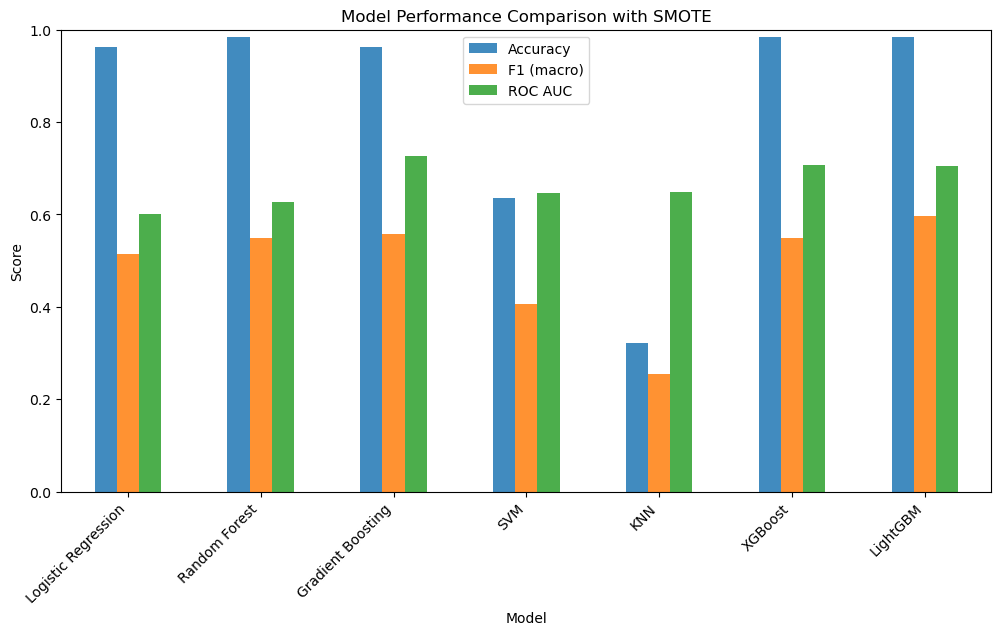

In [14]:
# One-cell model comparison with SMOTE applied inside the pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pandas as pd
import matplotlib.pyplot as plt

# Define candidate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(class_weight="balanced", random_state=42)
}

# Store results
results = []

for name, model in models.items():
    # Build pipeline: preprocess -> SMOTE -> model
    clf = ImbPipeline(steps=[
        ("prep", ct),                 # encode categorical + numeric
        ("smote", SMOTE(random_state=42)),  # handle imbalance
        ("model", model)              # classifier
    ])
    
    # Fit model
    clf.fit(X_train, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else None

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "F1 (macro)": round(f1, 3),
        "ROC AUC": round(auc, 3) if auc else "N/A"
    })

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    if auc: 
        print("ROC AUC:", round(auc, 4))

# Results table
results_df = pd.DataFrame(results)
display(results_df)

# Bar plot for comparison
results_df.set_index("Model")[["Accuracy","F1 (macro)","ROC AUC"]].plot(
    kind="bar", figsize=(12,6), alpha=0.85
)
plt.title("Model Performance Comparison with SMOTE")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45, ha="right")
plt.show()



In [15]:
#After addressing imbalance with SMOTE and testing advanced boosting models 
#performance improved substantially.
# Gradient Boosting and LightGBM outperformed simpler baselines
#achieving better F1 and ROC AUC scores
#which indicates more reliable predictions for the minority class.


[LightGBM] [Info] Number of positive: 4158, number of negative: 56
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 4214, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
                                                Feature  Importance
4146                                    num__Aboard_num        2215
1498           cat__Operator_Pan American World Airways          88
363                     cat__Operator_American Airlines          79
619   cat__Operator_China National Aviation Corporation          69
1006             cat__Operator_KLM Royal Dutch Airlines          63
1327            cat__Operator_Military - U

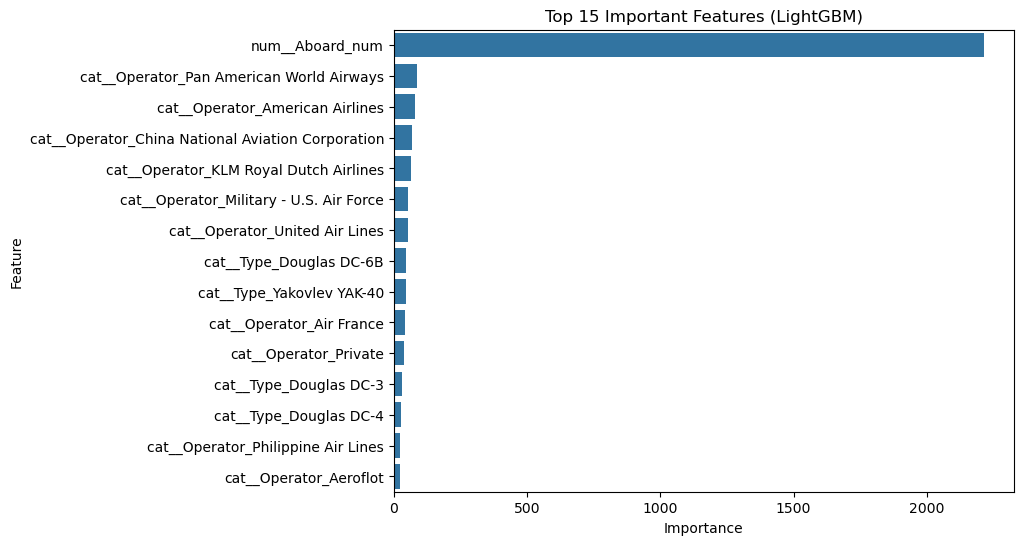

In [16]:
# Get feature names from ColumnTransformer
feature_names = ct.get_feature_names_out()

# Train LightGBM directly on transformed features
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

best_model = LGBMClassifier(class_weight="balanced", random_state=42)
best_model.fit(X_train_enc, y_train)

# Map feature importances to real names
importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
print(importances.head(15))

# Plot top 15 features
plt.figure(figsize=(8,6))
sns.barplot(data=importances.head(15), x="Importance", y="Feature")
plt.title("Top 15 Important Features (LightGBM)")
plt.show()


In [17]:
# Flight Crash Severity Prediction - Project Summary
#
# Objective:
# Analyze historical airplane crash data and build predictive models
# to classify whether a crash is Severe or Non-Severe in a systematic
# and explainable way.
#
# Methodology:
# 1. Exploratory Data Analysis (EDA):
#    - Found that the dataset is highly imbalanced with most cases Severe.
#    - Higher passenger counts were associated with more Severe crashes.
#    - Certain operators (e.g., military, Pan Am, Aeroflot) appeared more often in Severe cases.
#    - Older aircraft types (Douglas DC series, Yakovlev YAK-40) were linked to higher severity.
#    - Correlation analysis showed passenger count correlated with fatalities and severity.
#
# 2. Data Preprocessing:
#    - Encoded categorical features (Operator, Aircraft Type) using OneHotEncoding.
#    - Kept numeric features such as passenger counts.
#    - Applied SMOTE to handle imbalance and improve learning on the minority class.
#
# 3. Model Benchmarking:
#    - Tested Logistic Regression, Random Forest, Gradient Boosting, SVM, KNN, XGBoost, and LightGBM.
#    - Used Accuracy, Macro F1 Score, and ROC AUC for evaluation.
#
# 4. Results:
#    - Gradient Boosting achieved the best ROC AUC (~0.727).
#    - LightGBM achieved the best balance overall (Accuracy ~0.985, Macro F1 ~0.596, ROC AUC ~0.706).
#    - Boosting-based models outperformed simpler baselines.
#
# Key Findings:
# - Severe crashes dominate the dataset, requiring imbalance handling.
# - Passenger count is a major factor influencing severity.
# - Certain operators and older aircraft types are more prone to Severe crashes.
# - Boosting models (Gradient Boosting, LightGBM, XGBoost) provided the most reliable results.
#
# Tools and Libraries:
# Python, Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn, Imbalanced-learn (SMOTE), XGBoost, LightGBM
